# Test and refine code from LSSDS project to add in astropology library

In [6]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Xiansxu function
def getTimeSeries(perfunc, ### function to generate the signal
                  per, ### period
                  n,   ### number of sample points
                  sigma2, ### variance of the signal points
                  meandt, ### mean sample time, in units of period per
                  iregular_sample_dt): ### iregular sampling time [0,1]
                  
    if (n*meandt)<1:
        print('Warning: the signal lasts less than one period')

    if iregular_sample_dt == 0.0:
        regular_sample = True
        dt=np.ones(n)*meandt*per
    else:
        dt=(np.ones(n)+np.random.randn(n)*iregular_sample_dt)*meandt*per
        regular_sample = False
    t=np.cumsum(dt)
    signal=perfunc(t,per)+np.random.randn(n)*np.sqrt(sigma2)
    return t,signal,regular_sample 

def sin(t,per,amplitude=5):
    w=2*np.pi/per
    return amplitude*np.sin(w*t)+amplitude

In [28]:
n = 1000
per=2*np.pi ### keep this fixed
meandt=0.01 

t,y_control_sigma,regular_sample=getTimeSeries(sin, per, n, 0, meandt, 0.1)
sigma2_test=np.logspace(np.log10(0.01),np.log10(25),30)    ### variance of data points

# persistence_diagram_sigma2_control=persistence_diagram(y_control_sigma)

# plot_diagrams(persistence_diagram_sigma2_control)

In [34]:
dt=(np.ones(10)+np.random.randn(10)*1.)*meandt*per
t = np.cumsum(dt)
print(dt)
print(t)

[ 0.05815877  0.13871918 -0.02782143  0.04059542 -0.01999504  0.0567227
  0.13483559  0.11037905  0.02255038 -0.00261493]
[0.05815877 0.19687795 0.16905652 0.20965193 0.1896569  0.24637959
 0.38121519 0.49159424 0.51414461 0.51152968]


In [17]:
tata = []
for sigma2 in sigma2_test:

    _,y_sigma,_=getTimeSeries(sin, per, n, sigma2, meandt, 0.0)
    tata.append(y_sigma)

In [27]:
t[-5:]

array([62.58052566, 62.64335751, 62.70618937, 62.76902122, 62.83185307])

In [35]:
from astropology.simulate import time_series

In [36]:
tata = time_series(sin, per, n, 0, meandt, 0)

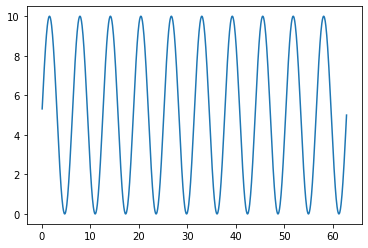

In [37]:
plt.plot(tata[0], tata[1])